# Introduction to Mean-CVaR Optimization

This notebook introduces NVIDIA's GPU-Accelerated Portfolio Optimization developer blueprint. We use the Mean-CVaR model to solve the problem of portfolio asset allocation. We show step-by-step how to pre-process input data, build the optimization model, solve the problem, and backtest the portfolio performance.
In particular, we will cover the following in this notebook: 
- Portfolio Optimization Setup – Import necessary libraries and configure solver settings.
- Data-preprocessing - calculate daily returns from input price data 
- Scenario generation - use cuML KDE to model returns distribution and generate return scenarios 
- Model Building - build the optimization problem with optional constraints
- Solving Optimization on GPU – call GPU/CPU solvers with customizable settings to solve the problem
- Backtesting - visualize and evaluate optimized portfolio
- Comparing CPU and GPU Performance – evaluate performance solving optimization problem on GPU vs CPU.


Before diving into portfolio optimization, we need to import the necessary libraries and perform initial setup if required.

## Table of Contents

1. [Portfolio Optimization Setup](#portfolio-optimization-setup)
   - GPU Check
   - Import Libraries

2. [Build a Mean-CVaR Problem](#build-a-mean-cvar-problem)
   - Mathematical Formulation

3. [Data Preprocessing and Model Setup](#data-preprocessing-and-model-setup)
   - Define Problem Parameters
   - Data Preparation
   - Build Mean-CVaR Problem

4. [Solve CVaR Optimization](#solve-cvar-optimization)
   - cuOpt GPU LP Solver
   - CPU Solver Comparison
   - Portfolio Visualization
   - cuOpt GPU MILP Solver

5. [Backtest Portfolio](#backtest-portfolio)
   - Testing Methods
   - Performance Metrics
   - Benchmark Comparison

6. [GPU vs. CPU: Comparison over Different Regimes](#gpu-vs-cpu-comparison-over-different-regimes)
   - Regime Analysis
   - Performance Comparison

7. [Appendix](#appendix)
   - Optional Parameter Constraints
   - cuOpt Python API


## Portfolio Optimization Setup
<a id='portfolio-optimization-setup'></a>

Before diving into portfolio optimization, we need to import the necessary libraries and perform initial setup if required.


In [1]:
import subprocess
import html
from IPython.display import display, HTML

def check_gpu():
    try:
        result = subprocess.run(["nvidia-smi"], capture_output=True, text=True, timeout=5)
        result.check_returncode()
        lines = result.stdout.splitlines()
        gpu_info = lines[2] if len(lines) > 2 else "GPU detected"
        gpu_info_escaped = html.escape(gpu_info)
        display(HTML(f"""
        <div style="border:2px solid #4CAF50;padding:10px;border-radius:10px;background:#e8f5e9;">
            <h3>✅ GPU is enabled</h3>
            <pre>{gpu_info_escaped}</pre>
        </div>
        """))
        return True
    except (subprocess.CalledProcessError, subprocess.TimeoutExpired, FileNotFoundError, IndexError) as e:
        display(HTML("""
        <div style="border:2px solid red;padding:15px;border-radius:10px;background:#ffeeee;">
            <h3>⚠️ GPU not detected!</h3>
            <p>This notebook requires a <b>GPU runtime</b>.</p>
            
            <h4>If running in Google Colab:</h4>
            <ol>
              <li>Click on <b>Runtime → Change runtime type</b></li>
              <li>Set <b>Hardware accelerator</b> to <b>GPU</b></li>
              <li>Then click <b>Save</b> and <b>Runtime → Restart runtime</b>.</li>
            </ol>
            
            <h4>If running in Docker:</h4>
            <ol>
              <li>Ensure you have <b>NVIDIA Docker runtime</b> installed (<code>nvidia-docker2</code>)</li>
              <li>Run container with GPU support: <code>docker run --gpus all ...</code></li>
              <li>Or use: <code>docker run --runtime=nvidia ...</code> for older Docker versions</li>
              <li>Verify GPU access: <code>docker run --gpus all nvidia/cuda:12.0.0-base-ubuntu22.04 nvidia-smi</code></li>
            </ol>
            
            <p><b>Additional resources:</b></p>
            <ul>
              <li><a href="https://docs.nvidia.com/datacenter/cloud-native/container-toolkit/install-guide.html" target="_blank">NVIDIA Container Toolkit Installation Guide</a></li>
            </ul>
        </div>
        """))
        return False

check_gpu()

True

In [2]:
import os
from cufolio import cvar_optimizer, cvar_utils, utils
from cufolio.cvar_parameters import CvarParameters
import cvxpy as cp

## Build a Mean-CVaR problem
<a id='build-a-mean-cvar-problem'></a>

The Mean-CVaR model captures the risk-return trade-off, aiming to maximize expected return while minimizing Conditional Value-at-Risk. 

Traditionally, variance of portfolio returns is used as the measure of risk. Here, we use Conditional Value-at-Risk (CVaR) as an alternative risk measure because it provides a more robust assessment of potential tail losses, and allows a data-driven approach to portfolio optimization without making assumptions on the underlying returns distribution. CVaR measures the average worst-case loss of a return distribution. Formally, for a loss random variable L,
$$CVaR = \mathbf{E}[L| L \leq VaR_\alpha (L)]$$
where  $VaR(L) = \inf{l: P(L \leq l) \geq \alpha  }$ is the $\alpha$-quantile of the loss distribution. CVaR is a more appropriate risk measure for portfolios that may contain assets with asymmetric return distribution - it has replaced Value-at-Risk(VaR) in Basel III market-risk rules; Mathematically, CVaR is a coherent risk measure—satisfying subadditivity, translation invariance, positive homogeneity, and monotonicity—which aligns with the diversification principles. Moreover, it has a computationally tractable transformation as a scenario-based optimization: for confidence level , the CVaR of portfolio w can be written in abstract form as 
$$CVaR(w) = \min_t\left\{t + \frac{1}{1-\alpha}\sum_{\omega \in \Omega}p(\omega)\max \{loss(w,\omega) - t, 0\}\right\}, $$
where $\Omega$ is the probability space of returns scenarios and $p(\omega)$ is the probability of a particular scenario $\omega \in \Omega$. Intuitively, this expression represents the portfolio’s average loss below the $\alpha$-quantile of all return scenarios. This scenario-based formulation makes CVaR more robust regardless whether the asset returns distribution is Gaussian or not. When we use linear loss, i.e. $loss(w,\omega) = -R(\omega)w$, with $R$ as the return scenarios matrix of size (num_scenarios, num_assets),  the minimization of the CVaR can be transformed into a linear program by replacing the $\max{\cdot,0}$ non-negative operator with an auxiliary variable $u$: 

\begin{align*}
&\text{max: } \mu^\top w - \lambda_{risk}\left(t + \frac{1}{1-\alpha}p^\top \mathbf{u}\right),\\
&\text{subject to: } \mathbf{u} \geq -R^\top \mathbf{w} - t.\\
\end{align*}



Then, we add constraints to model real-world trading limitations:
- Concentration limits on single assets
- Amount invested in risk-free assets (cash)
- Investment budgets
- Leverage constraints
- Turnover from an existing portfolio
- Cardinality constraints (maximum number of assets allowed in the portfolio)


The mathematical formulation of the problem is given as follows: 
\begin{align}
\text{max: } &\mu^\top w - \lambda_{risk}\left(t + \frac{1}{1-\alpha}p^\top \mathbf{u}\right),\\
\text{subject to: } & \mathbf{1}^\top \mathbf{w} = 1,\\
&\mathbf{u} \geq -R^\top \mathbf{w} - t,\\
& \mathbf{w}^{\min} \circ \mathbf{y} \leq \mathbf{w} \leq \mathbf{w}^{\max} \circ y, c^{\min} \leq c \leq c^{\max},\\
& L= \Vert \mathbf{w} \Vert_1 \leq L^{tar},\\
& T = \Vert \mathbf{w} - \mathbf{w}_{b}\Vert_1 \leq T^{tar},\\
& \sum{\mathbf{y}} \leq K,\\
&y_i \in \{0,1\}^N.
\end{align}

## Data Preprocessing and Model Setup
<a id='data-preprocessing-and-model-setup'></a>

We start with an example using a 397-stock subset of the S&P 500 stocks. We aim to build a long-short portfolio that maximizes risk-adjusted returns while meeting custom trading constraints. 

### 1. Define Problem Parameters
We define a `CvarParameters` object to encapsulate key constraints and settings for our portfolio optimization pipeline. This object configures the Mean-CVaR model with both required and optional parameters:

Required parameters: Settings like `w_min`, `w_max`, `risk_aversion`, `confidence`, `num_scen`, and `fit_type` must be specified to establish the basic optimization framework.

Optional constraints: Parameters such as `T_tar` (turnover constraint), `cvar_limit` (maximum CVaR threshold), and `cardinality` (portfolio size limit) are optional. Setting any of these to a non-`None` value will add the corresponding constraint to the Mean-CVaR model.

In [7]:
# Define CVaR optimization parameters for the S&P 500 example
cvar_params = CvarParameters(
    w_min={"NVDA":0.1, "others": -0.3}, w_max={"NVDA": 0.6, "others": 0.4},  # Asset weight allocation bounds
    c_min = 0.0, c_max = 0.2,  # Cash holdings bounds
    L_tar = 1.6, T_tar = None,  # Leverage and turnover (None for this example)
    cvar_limit = None,  # Max CVaR (None = unconstrained for this example)
    cardinality = None,  # Cardinality constraints
    risk_aversion= 1,  # Risk aversion level
    confidence = 0.95,  # CVaR confidence level (alpha)
    num_scen = 10000,  # Number of return scenarios to simulate
    fit_type = "kde"  # Return distribution estimation method
)

### 2. Data Preparation

We load closing prices from `2021-01-01` to `2024-01-01` and compute daily log‐returns. Next, we use the Kernel Density Estimator (KDE) to fit the returns and simulate  `cvar_params.num_scen` return scenarios. 

Key Components:

- Return Type (r`eturn_type`): "LOG" for log-returns.
- Historical Dataset (`data_path`): CSV file with adjusted closing prices.
- Regime Information (`regime_dict`): select the market regime (assuming that ).
- Scenario Generation: use `cuml.KDE` on GPU or `sklearn.KDE` on CPU to fit return distribution and sample scenarios.

In [8]:
# User inputs for S&P 500 example
dataset_name = "sp500"
dataset_format = "csv"

return_type = "LOG"
kde_device = "GPU"  # Device for KDE computation ("GPU" or "CPU")

# Set date range and file path
scenario_name = "recent" 
time_range = ("2021-01-01", "2024-01-01")
data_path = f"../data/stock_data/{dataset_name}.{dataset_format}"

# Define the regime for this example
regime_dict = {"name": scenario_name, "range": time_range}

# Compute returns for the S&P 500 example
returns_dict = cvar_utils.calculate_returns(
    data_path,
    regime_dict,
    return_type,
    cvar_params,  # CVaR parameters defined for this example
    device=kde_device
)

### 3. Build Mean-CVaR Problem
We take the processed data `returns_dict` and the problem parameters `cvar_params` and formulates the problem `cvar_problem`. 


In [6]:
# Instantiate CVaR optimization problem for the S&P 500 example
cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict,
    cvar_params=cvar_params
)

## Solve CVaR Optimization
<a id='solve-cvar-optimization'></a>

### cuOpt GPU LP Solver
We then call the cuOpt LP solver and returns the optimized portfolio. One may also provide customized configurations to the cuOpt LP solver including solver mode, accuracy, etc. 

cuOpt LP solver supports four solve methods: choose one of the following by setting `solver_method`: 
1. PDLP algorithm has three solver modes: choose one of the following by setting `solver_mode`:
    - "Stable2": balance speed and accuracy
    - "Methodical1": prioritize accuracy
    - "Fast1": prioritize speed

2. Dual Simplex
3. Barrier Method
4. Concurrent: runs all three algorithms and return the fastest.

For details, see cuOpt documentation: https://docs.nvidia.com/cuopt/user-guide/latest/introduction.html.


In [ ]:
# GPU solver settings
gpu_solver_settings = {"solver": cp.CUOPT, "verbose": True, 
                       "solver_method": "PDLP", 
                       "solver_mode": "Stable2", 
                       "time_limit":15, 
                       "optimality": 1e-4
                       }

# Solve on GPU
gpu_results, gpu_portfolio = cvar_problem.solve_optimization_problem(solver_settings=gpu_solver_settings)

(CVXPY) Nov 05 09:49:23 PM: Your problem has 10399 variables, 10002 constraints, and 2 parameters.
(CVXPY) Nov 05 09:49:23 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 05 09:49:23 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 05 09:49:23 PM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 05 09:49:23 PM: Compiling problem (target solver=CUOPT).
(CVXPY) Nov 05 09:49:23 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CUOPT
(CVXPY) Nov 05 09:49:23 PM: Applying reduction Dcp2Cone
(CVXPY) Nov 05 09:49:23 PM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 05 09:49:23 PM: Applying reduction ConeMatrixStuffing


                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 05 09:49:24 PM: Applying reduction CUOPT
(CVXPY) Nov 05 09:49:25 PM: Finished problem compilation (took 1.769e+00 seconds).
(CVXPY) Nov 05 09:49:25 PM: (Subsequent compilations of this problem, using the same arguments, should take less time.)
(CVXPY) Nov 05 09:49:25 PM: Invoking solver CUOPT  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------


(CVXPY) Nov 05 09:49:26 PM: Problem status: optimal
(CVXPY) Nov 05 09:49:26 PM: Optimal value: -1.400e-03
(CVXPY) Nov 05 09:49:26 PM: Compilation took 1.769e+00 seconds
(CVXPY) Nov 05 09:49:26 PM: Solver (including time spent in interface) took 1.154e+00 seconds


Setting parameter log_to_console to true
Setting parameter method to 1
Setting parameter absolute_dual_tolerance to 1.000000e-04
Setting parameter relative_dual_tolerance to 1.000000e-04
Setting parameter absolute_primal_tolerance to 1.000000e-04
Setting parameter relative_primal_tolerance to 1.000000e-04
Setting parameter absolute_gap_tolerance to 1.000000e-04
Setting parameter relative_gap_tolerance to 1.000000e-04
Setting parameter time_limit to 1.500000e+01
cuOpt version: 25.10.0, git hash: 99e549c, host arch: x86_64, device archs: 75-real,80-real,86-real,90a-real,100f-real,120a-real,120
CPU: Intel(R) Xeon(R) Platinum 8480C, threads (physical/logical): 112/224, RAM: 1435.63 GiB
CUDA 13.0, device: NVIDIA H200 (ID 0), VRAM: 139.80 GiB
CUDA device UUID: 64fffffff0ffffffcdffffff8a-0cfffffff

Solving a problem with 10796 constraints, 10796 variables (0 integers), and 3992383 nonzeros
Problem scaling:
Objective coefficents range:          [6e-07, 5e-02]
Constraint matrix coefficients ran

### Solve on CPU solver
Using CVXPY as the modeling API, we can easily change to any CPU solver supported on CVXPY to solve the same problem and compare the performance. Just change the solver in the solver settings dictionary.

In [ ]:
cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict,
    cvar_params=cvar_params,
    api_settings={"api": "cvxpy"}
)

# CPU solver settings
cpu_solver_settings = {"solver":cp.HIGHS, "verbose": False, "highs_options": {"solver":"simplex"}}

# Solve on CPU
cpu_results, cpu_portfolio = cvar_problem.solve_optimization_problem(solver_settings=cpu_solver_settings)


CVaR OPTIMIZATION RESULTS
PROBLEM CONFIGURATION
------------------------------
Solver:              HIGHS
Regime:              recent
Time Period:         2021-01-01 to 2024-01-01
Scenarios:           10,000
Assets:              397
Confidence Level:    95.0%

PERFORMANCE METRICS
------------------------------
Expected Return:     0.002511 (0.2511%)
CVaR (95%):          0.023023 (2.3023%)
Objective Value:     -0.001400

SOLVING PERFORMANCE
------------------------------
Setup Time:          0.4206 seconds
CVXPY API Overhead:  0.5288 seconds
Solve Time:          19.6614 seconds

OPTIMAL PORTFOLIO ALLOCATION
------------------------------

PORTFOLIO: HIGHS_OPTIMAL
----------------------------------------
Period: 2021-01-01 to 2024-01-01

LONG POSITIONS (11 assets)
-------------------------
LLY         0.294 ( 29.43%)
MCK         0.189 ( 18.94%)
NVDA        0.149 ( 14.91%)
IRM         0.116 ( 11.62%)
JBL         0.096 (  9.65%)
IT          0.095 (  9.49%)
STLD        0.072 (  7.17%)
COP 

In [13]:
# Compare results between GPU and CPU solvers
utils.compare_results(gpu_results, cpu_results)


SOLVER COMPARISON
Solver          Solve Time (s)  Objective    Return     CVaR      
-----------------------------------------------------------------
CUOPT (CVXPY)   0.8626          -0.001400    0.002514   0.023079  
CPU (HIGHS)     19.6614         -0.001400    0.002511   0.023023  

Objective Differences:
CUOPT (CVXPY) vs CPU (HIGHS): 0.00000017



### Optional: Visualize Optimized Portfolio

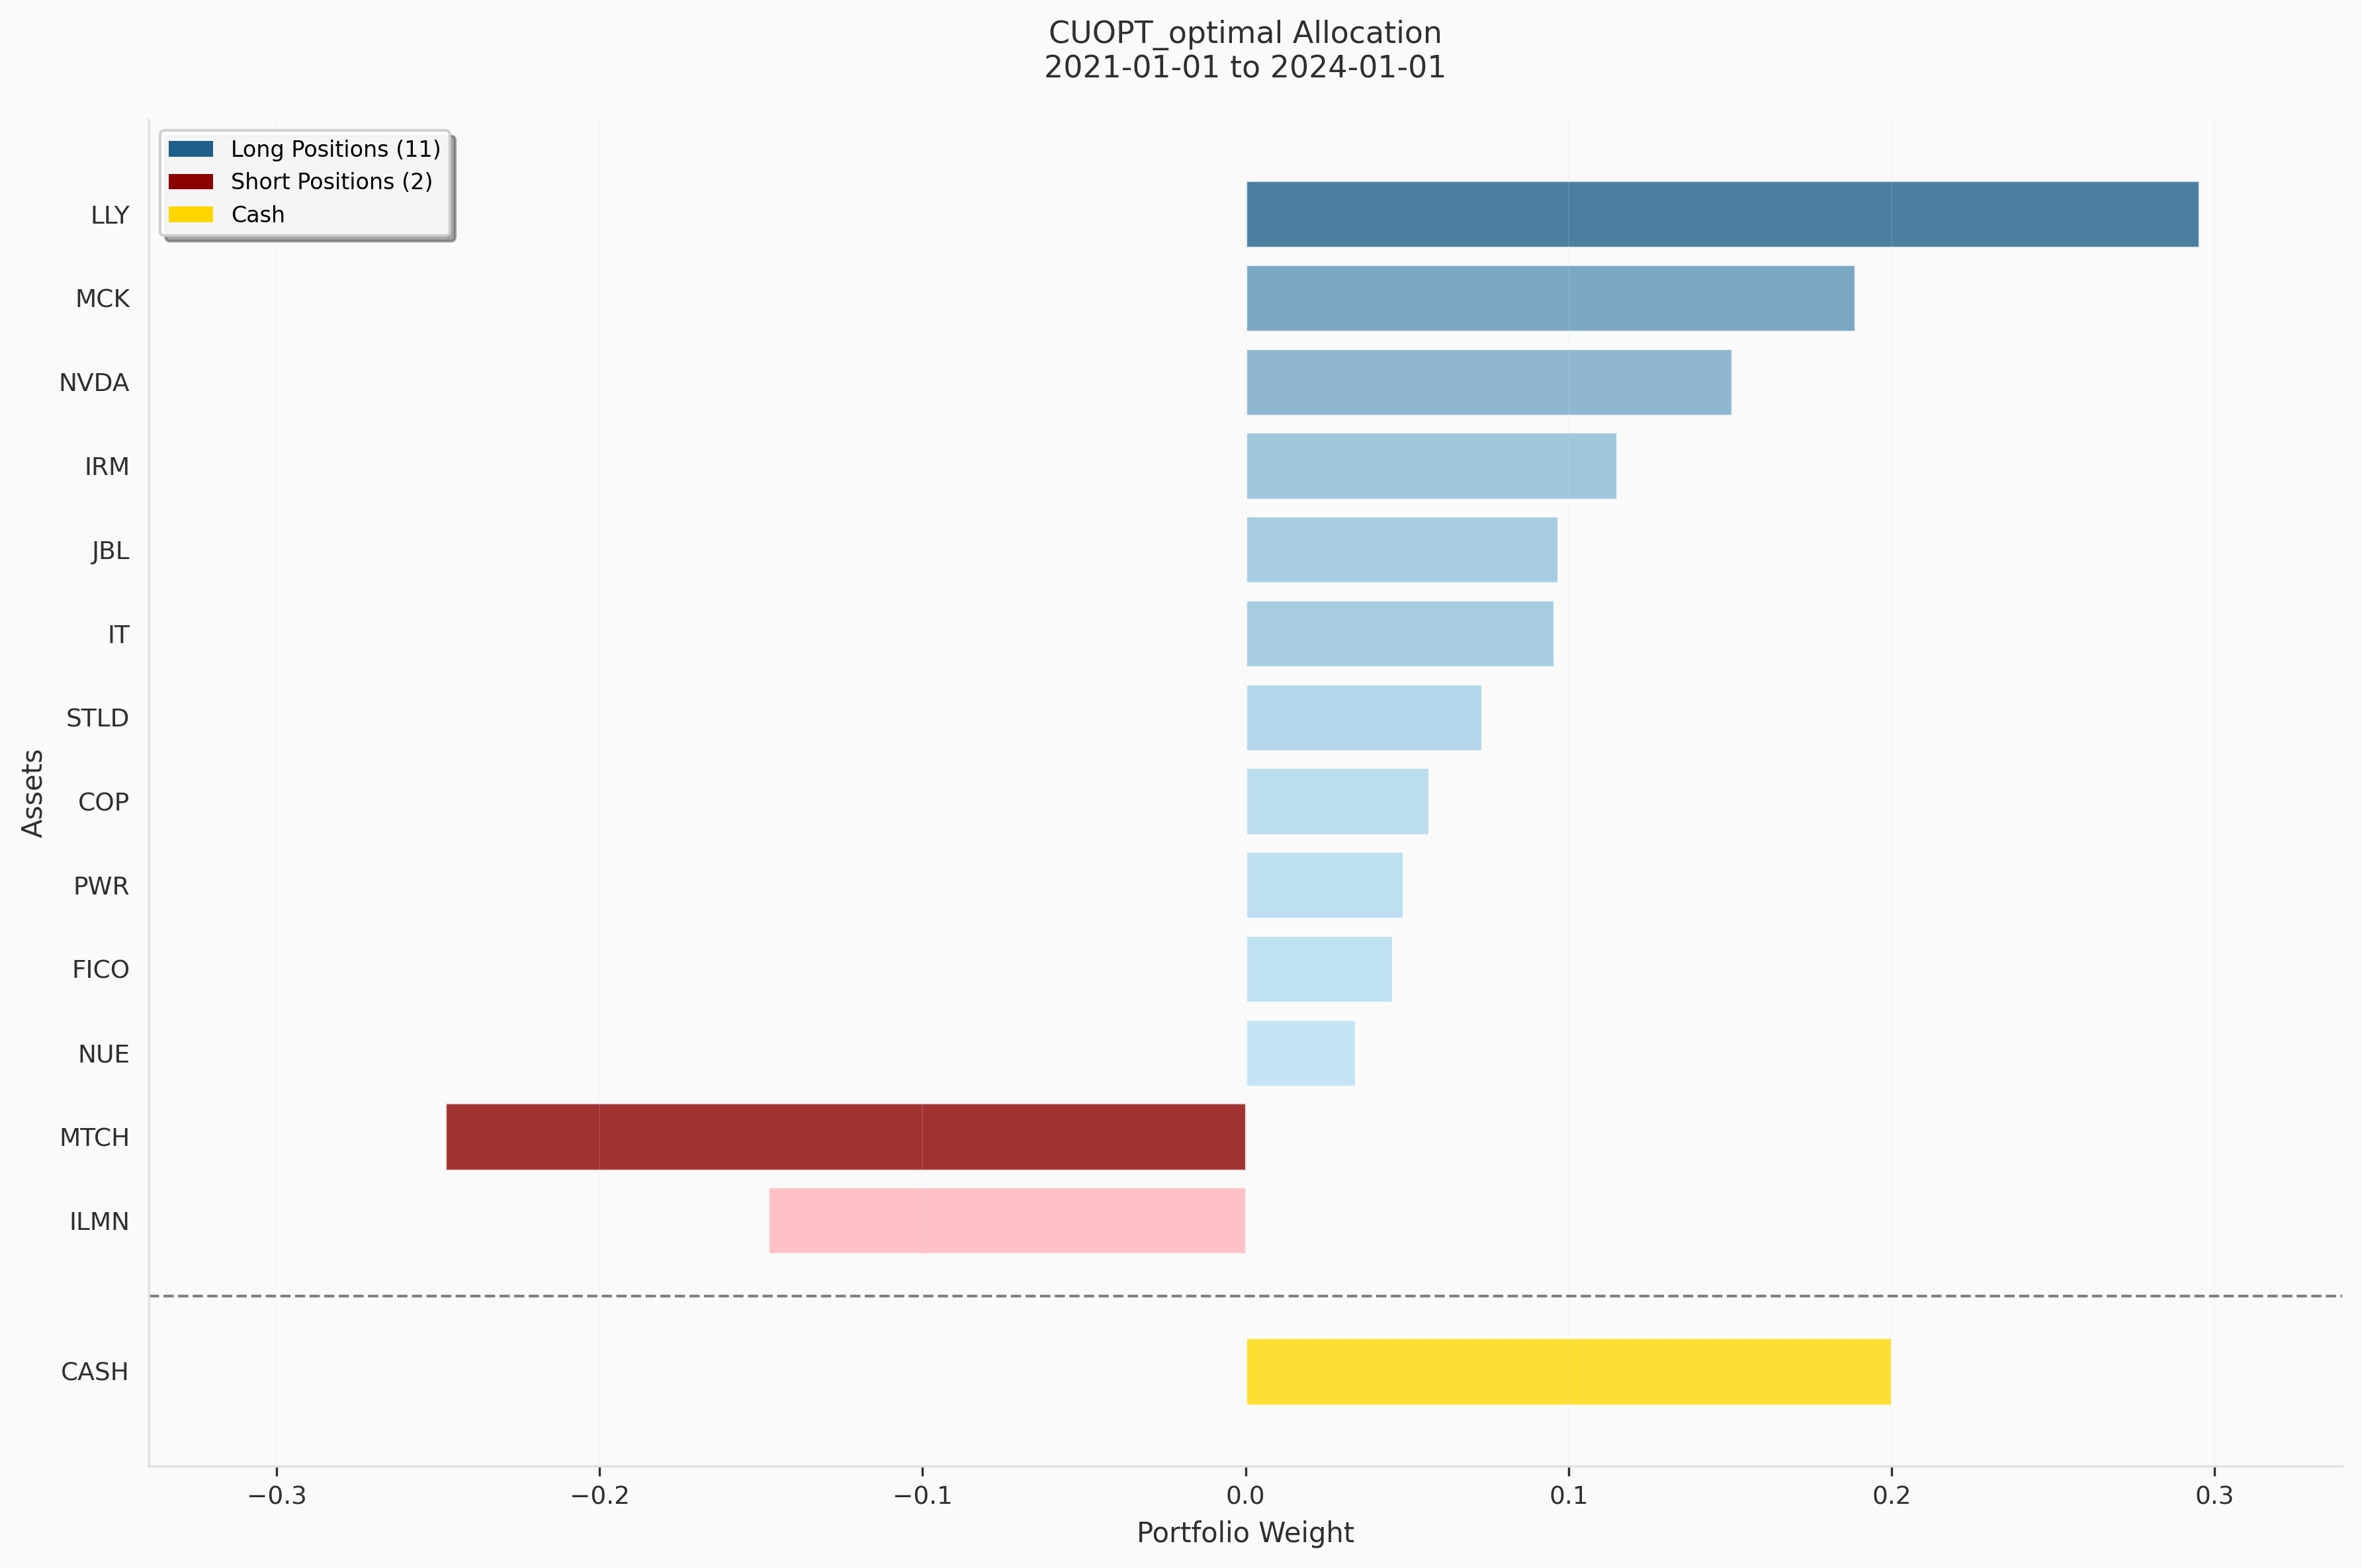

In [14]:
# Plot portfolio
ax = gpu_portfolio.plot_portfolio(show_plot = True, min_percentage = 1)

### Adding Cardinality Constraint: Mixed-Integer Linear Program 

A **cardinality constraint** limits the maximum number of assets held in the portfolio, promoting sparsity and reducing transaction costs. This constraint transforms the problem into a **Mixed-Integer Linear Program (MILP)** because it requires binary decision variables to track whether each asset is included.

**Mathematical Formulation:**

We introduce binary variables $y_i \in \{0,1\}$ for each asset $i$, where:
- $y_i = 1$ if asset $i$ is held in the portfolio (i.e., $w_i \neq 0$)
- $y_i = 0$ otherwise

The cardinality constraint is then:
$$\sum_{i=1}^{N} y_i \leq K$$
where $K$ is the maximum number of assets allowed. To link the binary variables with the continuous weights, we add:
$$w_i^{\min} \cdot y_i \leq w_i \leq w_i^{\max} \cdot y_i, \quad \forall i$$

This ensures that $w_i = 0$ when $y_i = 0$, and $w_i$ can take non-zero values only when $y_i = 1$. The presence of integer decision variables $y_i$ makes this a MILP.

**Model Set-Up:** 

To set up a MILP problem, we just need to set the `cardinality` to an integer number (max number of assets allowed in the portfolio) when instantiating the `CvarParameters` dataclass. cuOpt offers MILP solvers with a GPU-accelerated heuristics algorithm and a CPU branch-and-cut algorithm. Since MILPs are much challenging to solve in general, we should expect a longer solve time. After solving, one can verify that the number of assets in the portfolio is indeed less than or equal to the cardinality constraint. 


In [12]:
# Define CVaR optimization parameters for the S&P 500 example
milp_cvar_params = CvarParameters(
    w_min={"NVDA":0.1, "others": -0.3}, w_max={"NVDA": 0.6, "others": 0.4},  # Asset weight allocation bounds
    c_min = 0.0, c_max = 0.2,  # Cash holdings bounds
    L_tar = 1.6, T_tar = None,  # Leverage and turnover (None for this example)
    cvar_limit = None,  # Max CVaR (None = unconstrained for this example)
    cardinality = 10,  # Cardinality constraints
    risk_aversion= 1,  # Risk aversion level
    confidence = 0.95,  # CVaR confidence level (alpha)
    num_scen = 10000,  # Number of return scenarios to simulate
    fit_type = "kde"  # Return distribution estimation method
)

# Instantiate the MILP problem
milp_cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict,
    cvar_params=milp_cvar_params
)

# cuOpt MILP solver settings
gpu_solver_settings = {"solver": cp.CUOPT, "verbose": False, 
                       "time_limit":200, 
                       "mip_absolute_tolerance": 1e-4
                       }

# Solve the MILP problem
milp_results, milp_portfolio = milp_cvar_problem.solve_optimization_problem(solver_settings=gpu_solver_settings)

(CVXPY) Nov 06 12:17:45 AM: Your problem has 10796 variables, 10797 constraints, and 3 parameters.
(CVXPY) Nov 06 12:17:45 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Nov 06 12:17:45 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Nov 06 12:17:45 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Nov 06 12:17:45 AM: Compiling problem (target solver=CUOPT).
(CVXPY) Nov 06 12:17:45 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CUOPT
(CVXPY) Nov 06 12:17:45 AM: Applying reduction Dcp2Cone
(CVXPY) Nov 06 12:17:45 AM: Applying reduction CvxAttr2Constr
(CVXPY) Nov 06 12:17:45 AM: Applying reduction ConeMatrixStuffing


MIXED-INTEGER LINEAR PROGRAMMING (MILP) SETUP
Cardinality Constraint: K ≤ 10 assets
                                     CVXPY                                     
                                     v1.7.3                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------


(CVXPY) Nov 06 12:17:46 AM: Applying reduction CUOPT
(CVXPY) Nov 06 12:17:47 AM: Finished problem compilation (took 1.309e+00 seconds).
(CVXPY) Nov 06 12:17:47 AM: (Subsequent compilations of this problem, using the same arguments, should take less time.)
(CVXPY) Nov 06 12:17:47 AM: Invoking solver CUOPT  to obtain a solution.


-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------


(CVXPY) Nov 06 12:18:12 AM: Problem status: optimal
(CVXPY) Nov 06 12:18:12 AM: Optimal value: -1.369e-03
(CVXPY) Nov 06 12:18:12 AM: Compilation took 1.309e+00 seconds
(CVXPY) Nov 06 12:18:12 AM: Solver (including time spent in interface) took 2.566e+01 seconds


Setting parameter log_to_console to true
Setting parameter mip_absolute_tolerance to 1.000000e-04
Setting parameter time_limit to 2.000000e+02
cuOpt version: 25.10.0, git hash: 99e549c, host arch: x86_64, device archs: 75-real,80-real,86-real,90a-real,100f-real,120a-real,120
CPU: Intel(R) Xeon(R) Platinum 8480C, threads (physical/logical): 112/224, RAM: 1428.09 GiB
CUDA 13.0, device: NVIDIA H200 (ID 0), VRAM: 139.80 GiB
CUDA device UUID: 64fffffff0ffffffcdffffff8a-0cfffffff

Solving a problem with 11591 constraints, 11193 variables (397 integers), and 3994368 nonzeros
Problem scaling:
Objective coefficents range:          [6e-07, 5e-02]
Constraint matrix coefficients range: [8e-09, 1e+00]
Constraint rhs / bounds range:        [0e+00, 1e+01]
Variable bounds range:                [1e-01, 1e+00]

Original problem: 11591 constraints, 11193 variables, 3994368 nonzeros
Calling Papilo presolver
Presolve status: reduced the problem
Presolve removed: 3 constraints, 2 variables, 8 nonzeros
Preso

## Backtest Portfolio
<a id='backtest-portfolio'></a>

The `portfolio_backtester` evaluates portfolio performance against historical data and benchmarks. It supports multiple testing methods and calculates comprehensive performance metrics:

**Testing Methods:**
- **Historical**: Uses actual historical return data
- **KDE Simulation**: Generates scenarios using Kernel Density Estimation
- **Gaussian Simulation**: Generates scenarios from multivariate normal distribution

**Performance Metrics:**
- **Sharpe Ratio**: Risk-adjusted return relative to volatility (annualized)
- **Sortino Ratio**: Return relative to downside deviation (annualized)
- **Maximum Drawdown**: Largest peak-to-trough decline

**Benchmarking:** By default, compares against an equal-weight portfolio. Custom benchmarks can also be provided.

The backtester visualizes cumulative returns over time and allows comparison between the optimized portfolio and benchmark strategies.

The `cut_off_date` marks the boundary between training data used for optimization and test data used for out-of-sample evaluation. One can test whether the optimized portfolio is robust to potential regime shifts. 

In [15]:
# Define test regime and calculate test returns
test_regime_dict = {"name": "test_recent", "range": ("2023-09-01", "2024-07-01")}
test_returns_dict = cvar_utils.calculate_returns(data_path, test_regime_dict, return_type, cvar_params)

# Backtest settings
test_method = "historical"
risk_free = 0.0

,returns,cumulative returns,mean portfolio return,sharpe,sortino,max drawdown
portfolio name,,,,,,
CUOPT_optimal,"[0.003974734464222271, 0.0015455638932598034, ...","[1.003982644197477, 1.00553556328051, 1.016176...",0.002825,3.293396,5.986499,0.077173
AMZN-JPM,"[-0.0064417289014207305, -0.010386334705014998...","[0.9935789745549939, 0.9833127373471416, 0.994...",0.001345,1.628412,2.553817,0.136418
AAPL-MSFT,"[0.009376115317883675, -0.01179679161502003, -...","[1.0094202087878543, 0.9975822511770992, 0.983...",0.000458,0.72608,1.085632,0.073053
NKE-MCD,"[-0.00916418488056512, -0.009068958908961732, ...","[0.9908776782835054, 0.9819320743044023, 0.983...",-0.000213,-0.389702,-0.565025,0.131192


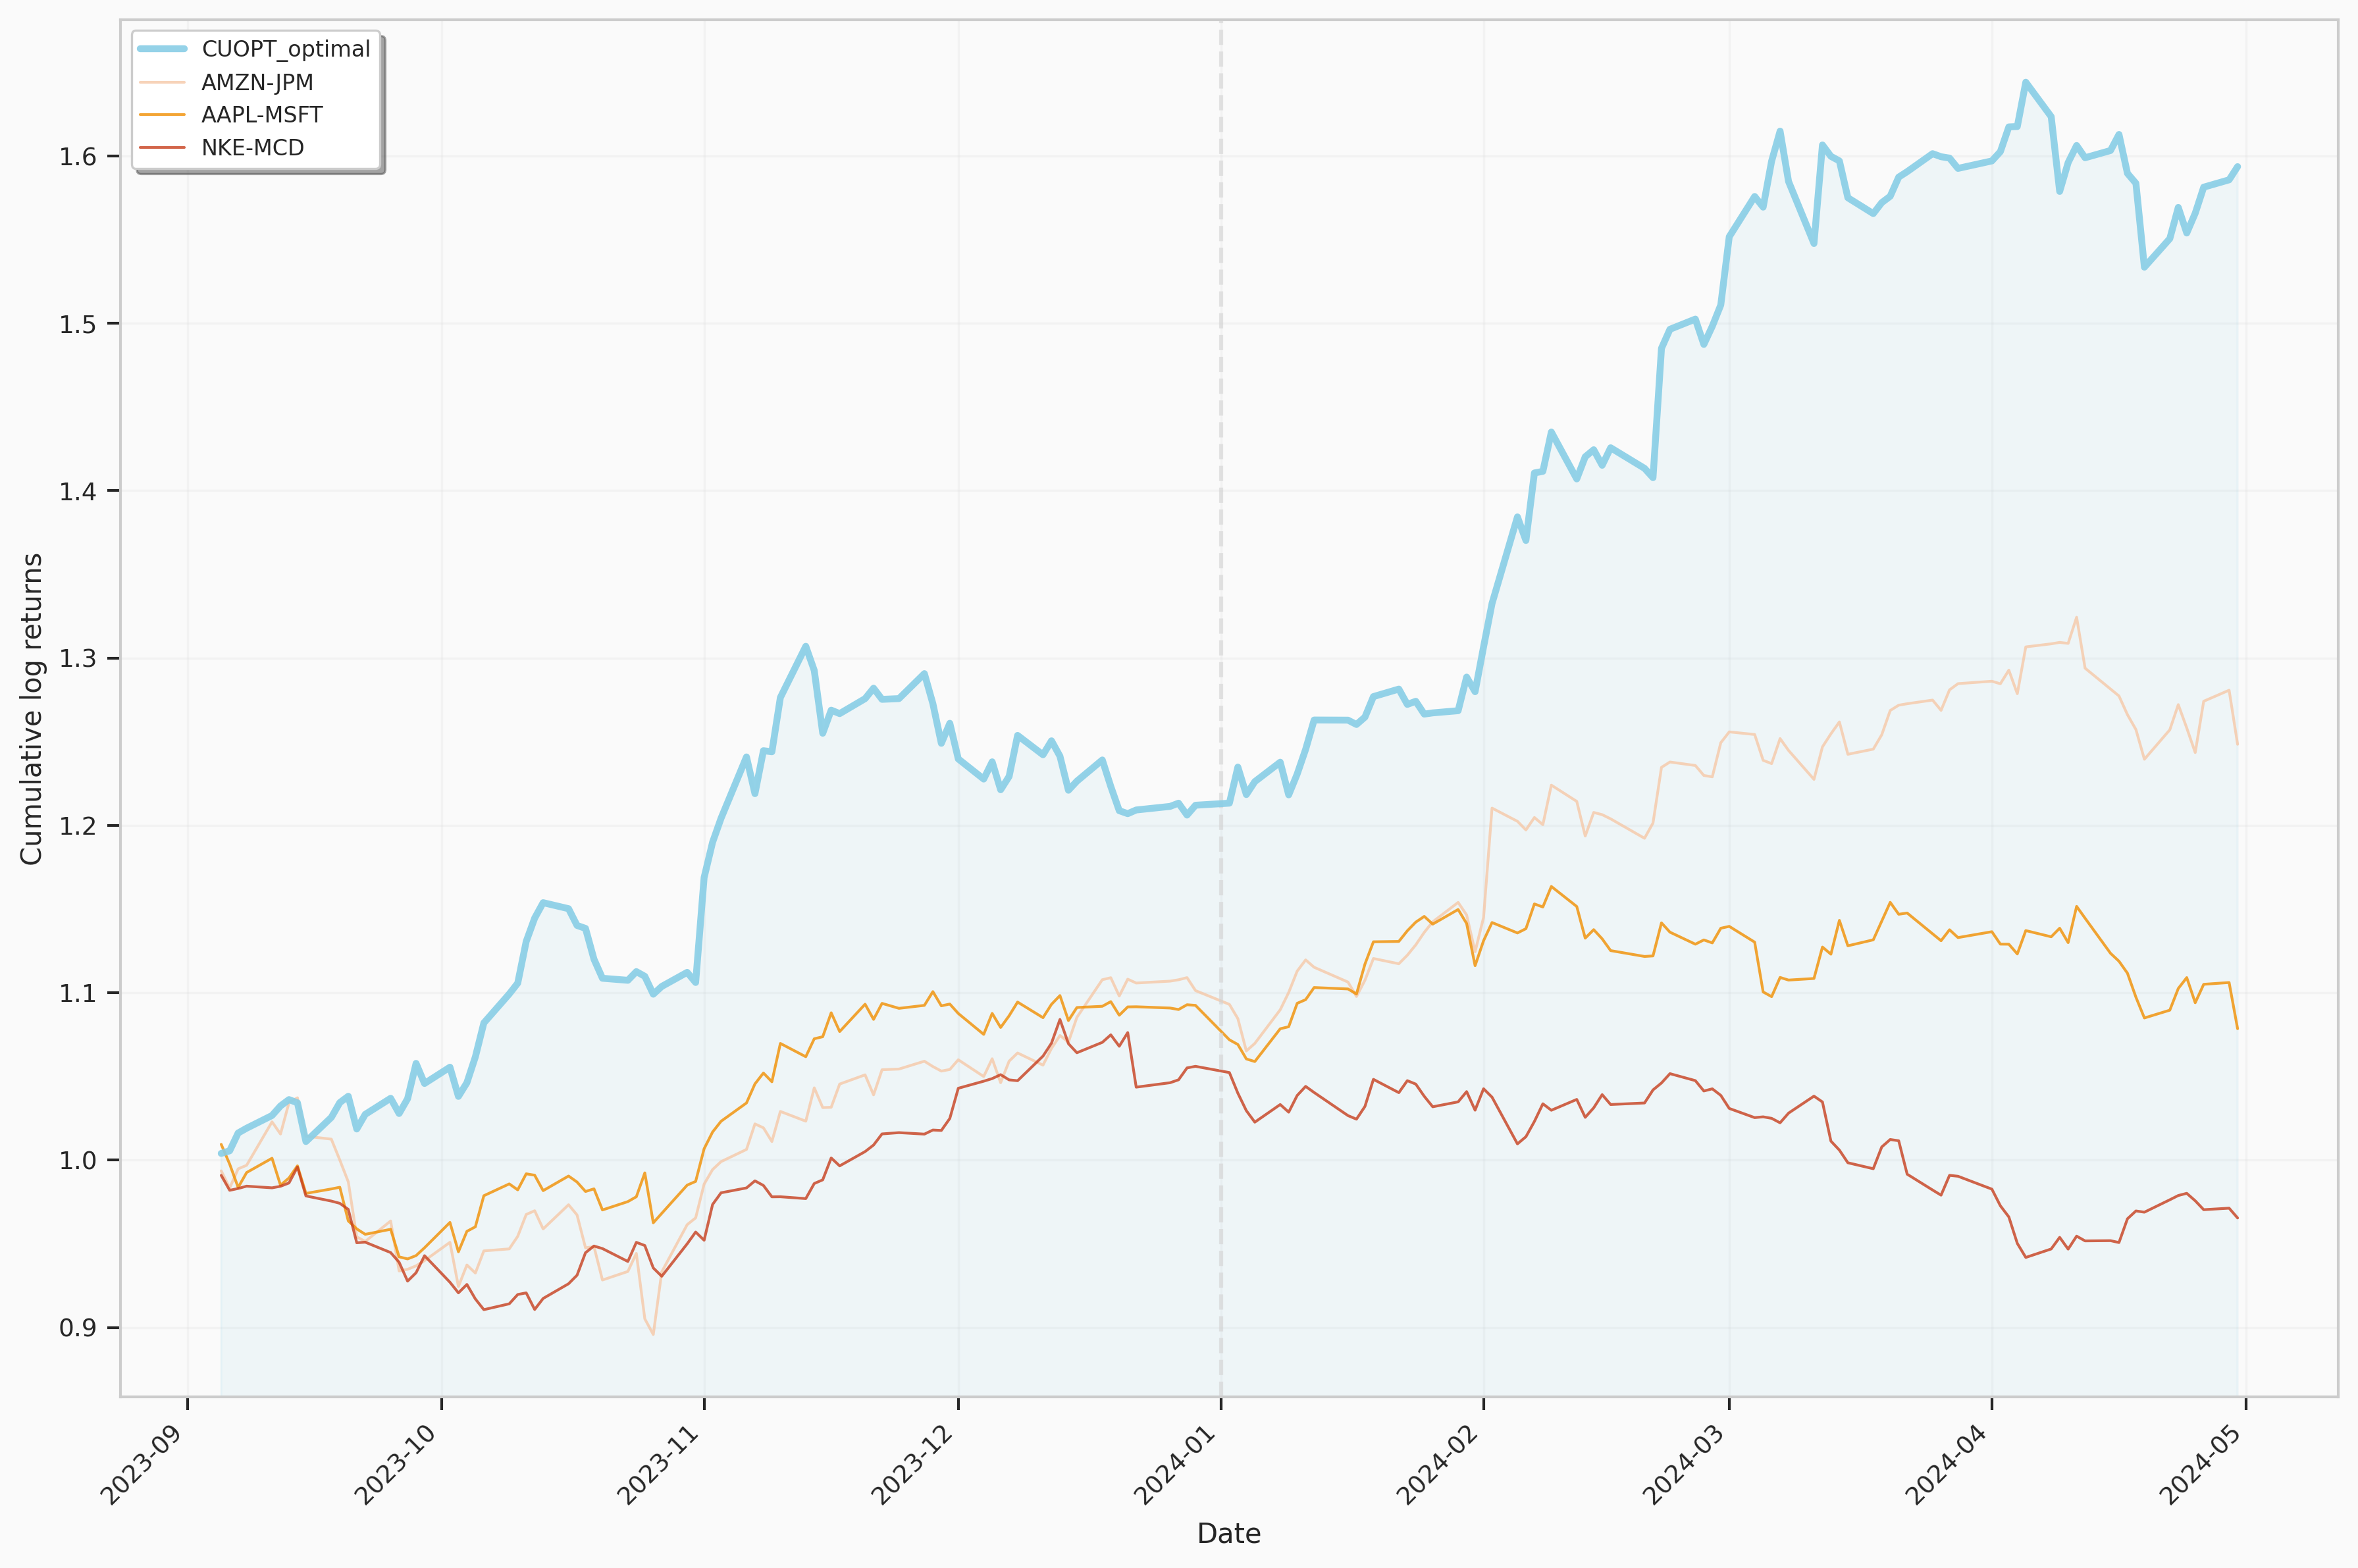

In [24]:
from cufolio import backtest, portfolio

# (Optional) Compare results between optimized portfolio and user-defined portfolios
portfolios_dict = {'AMZN-JPM':({'AMZN': 0.72, 'JPM': 0.18}, 0.1),\
                   'AAPL-MSFT': ({'AAPL': 0.29, 'MSFT': 0.61}, 0.1),\
                   'NKE-MCD': ({'MCD': 0.65, 'NKE': 0.25}, 0.1)}

benchmark_portfolios = cvar_utils.generate_user_input_portfolios(portfolios_dict, test_returns_dict)

# Uncomment the following lineto use equal-weight benchmark portfolio
# benchmark_portfolios = None 

# Set cut-off date for backtest visualization
cut_off_date = regime_dict["range"][1]

# Create backtester and run backtest
backtester = backtest.portfolio_backtester(gpu_portfolio, test_returns_dict, risk_free, test_method, benchmark_portfolios = benchmark_portfolios)

backtest_result,_ = backtester.backtest_against_benchmarks(plot_returns = True, cut_off_date = cut_off_date)

backtest_result

Combined plot saved: ../result/backtest/combined_cuopt_optimal_historical_analysis.png


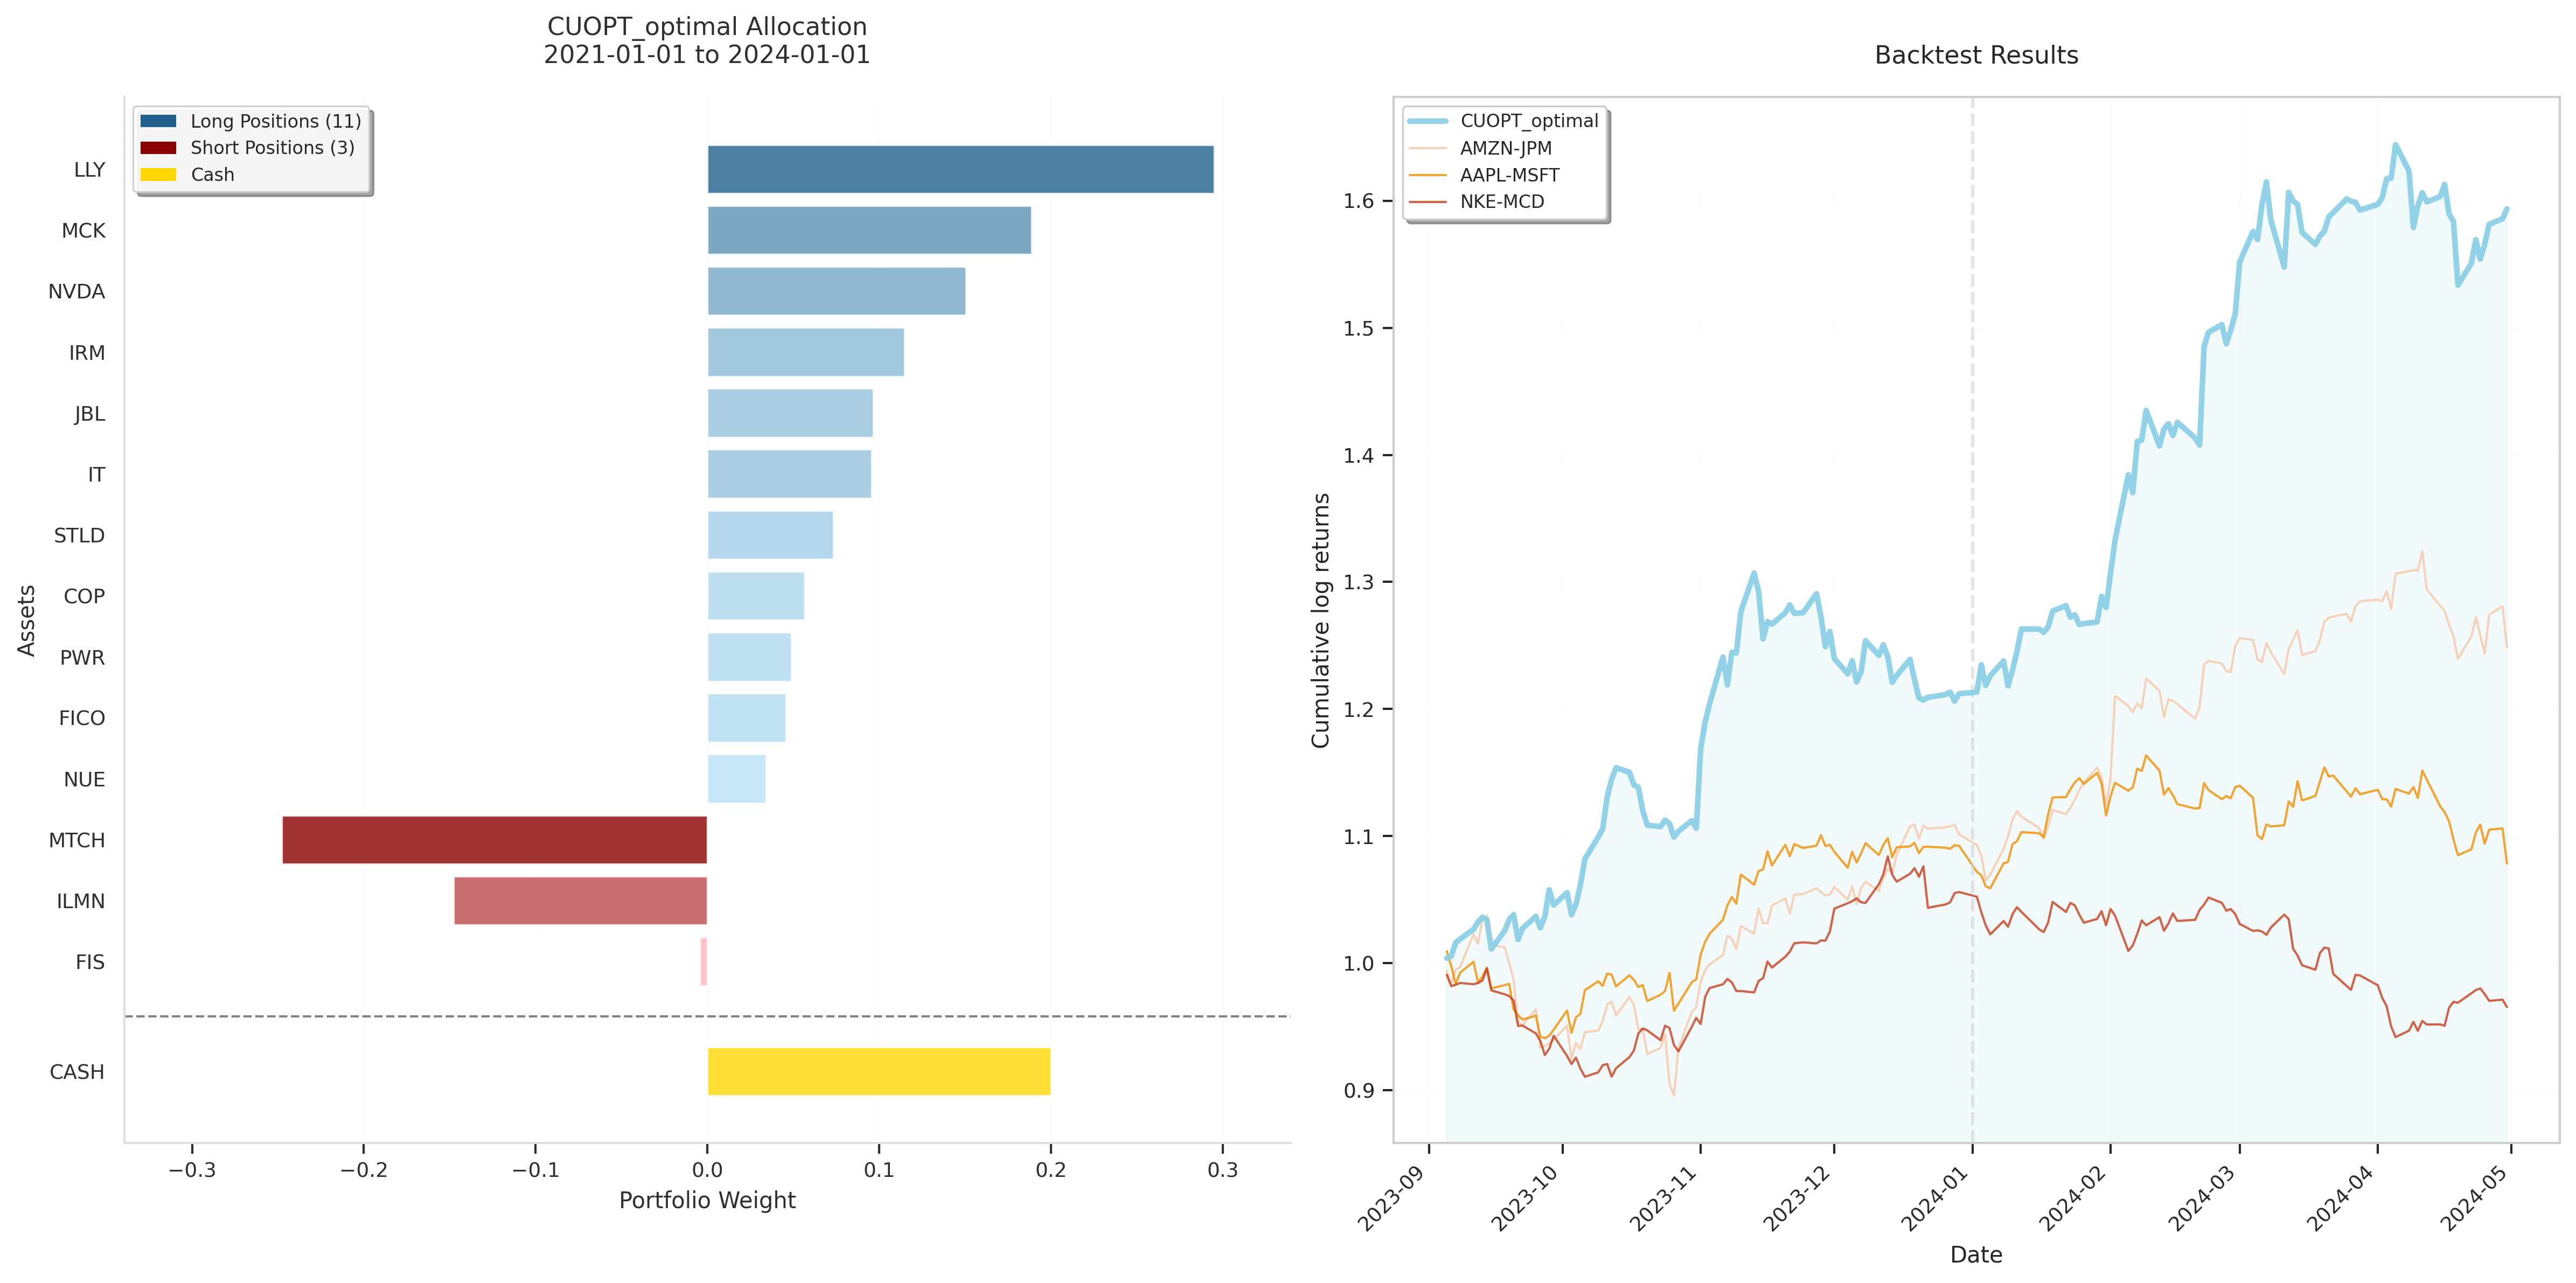

In [25]:
# Plot portfolio and backtest results side by side
utils.portfolio_plot_with_backtest(portfolio=gpu_portfolio, backtester=backtester, cut_off_date= cut_off_date, backtest_plot_title="Backtest Results", save_plot = True, results_dir = "../result/backtest")

## GPU vs. CPU: Comparison over Different Regimes
<a id='gpu-vs-cpu-comparison-over-different-regimes'></a>

To further compare the performance of cuOpt GPU solver vs. CPU solvers, we can compare CPU vs. GPU performance over solving the same problems over different market regimes. The function `cvar_utils.optimize_market_regimes` generates Mean-CVaR optimization problems iteratively over different regimes from `regime_comparison_selected_dict`, solve each problem using all the solvers specified in `solver_settings_list`, and returns a dataframe of results. 

In [3]:
# CVaR parameters for regime comparison
regime_comparison_cvar_params = CvarParameters(
    w_min={"NVDA":0.1, "others": -0.3}, w_max={"NVDA": 0.6, "others": 0.4},  # Asset weight allocation bounds
    c_min=0.0, c_max=0.2,  # Cash holdings bounds
    L_tar=1.6, T_tar=None,  # Leverage and turnover (None for this example)
    cvar_limit=None,  # Max CVaR (None = unconstrained for this example)
    cardinality = None,  # Cardinality constraints
    risk_aversion=1,  # Risk aversion level
    confidence=0.95,  # CVaR confidence level (alpha)
    num_scen=10000,  # Number of return scenarios to simulate
    fit_type="kde"  # Return distribution estimation method
)

# User inputs for regime comparison
regime_comparison_dataset_name = "sp500"
regime_comparison_return_type = "LOG"

# Prepare output directory and file name
regime_comparison_output_folder = "../result/regime_results"
os.makedirs(regime_comparison_output_folder, exist_ok=True)
regime_comparison_results_csv_path = os.path.join(
    regime_comparison_output_folder,
    f"both_results_{regime_comparison_dataset_name}_{regime_comparison_cvar_params.num_scen}.csv"
)

# Regime settings (customize as needed)
regime_comparison_selected_dict = {
    "pre_crisis"                  : ("2005-01-01", "2007-10-01"),
    "crisis"                      : ("2007-10-01", "2009-04-01"),
    "post_crisis"                 : ("2009-06-30", "2014-06-30"),
    "oil_price_crash"             : ("2014-06-01", "2016-03-01"),
    "FAANG_surge"                 : ("2015-01-01", "2021-01-01"),
    "covid"                       : ("2020-01-01", "2023-01-01"),
    "recent"                      : ("2022-01-01", "2024-07-01")
}

# List of solvers to compare - any supported solver on CVXPY can be used.
solver_settings_list = [
    {"solver": cp.HIGHS, "verbose": False, "highs_options":{"optimality_tolerance":1e-4}}, 
    #{"solver": cp.CLARABEL, "verbose": False},
    {"solver":cp.CUOPT, "verbose": False, "solver_method": "PDLP", "optimality": 1e-4}
]

regime_comparison_dataset_path = f"../data/stock_data/{regime_comparison_dataset_name}.csv"

# Run CPU vs. GPU comparison across selected regimes
regime_comparison_results_df = cvar_utils.optimize_market_regimes(
    input_file_name=regime_comparison_dataset_path,
    return_type=regime_comparison_return_type,
    all_regimes=regime_comparison_selected_dict,
    cvar_params=regime_comparison_cvar_params,
    solver_settings_list=solver_settings_list,
    results_csv_file_name=regime_comparison_results_csv_path
)

print(f"Regime comparison results saved to: {regime_comparison_results_csv_path}")

Processing Regime: pre_crisis



--- Testing Solver: HIGHS ---

CVaR OPTIMIZATION RESULTS
PROBLEM CONFIGURATION
------------------------------
Solver:              HIGHS
Regime:              pre_crisis
Time Period:         2005-01-01 to 2007-10-01
Scenarios:           10,000
Assets:              397
Confidence Level:    95.0%

PERFORMANCE METRICS
------------------------------
Expected Return:     0.003115 (0.3115%)
CVaR (95%):          0.023685 (2.3685%)
Objective Value:     -0.001802

SOLVING PERFORMANCE
------------------------------
Setup Time:          0.3782 seconds
CVXPY API Overhead:  0.7760 seconds
Solve Time:          18.6433 seconds

OPTIMAL PORTFOLIO ALLOCATION
------------------------------

PORTFOLIO: HIGHS_OPTIMAL
----------------------------------------
Period: 2005-01-01 to 2007-10-01

LONG POSITIONS (16 assets)
-------------------------
DLR         0.312 ( 31.18%)
MNST        0.145 ( 14.54%)
AAPL        0.123 ( 12.30%)
NVDA        0.100 ( 10.00%)
ILMN        0.081 (  8.10%)
SBAC        0.078 (  7.81

/home/scratch.phuo_wwfo/github/cufolio/src/cvar_utils.py:371: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result_dataframe = pd.concat(



--- Testing Solver: HIGHS ---

CVaR OPTIMIZATION RESULTS
PROBLEM CONFIGURATION
------------------------------
Solver:              HIGHS
Regime:              crisis
Time Period:         2007-10-01 to 2009-04-01
Scenarios:           10,000
Assets:              397
Confidence Level:    95.0%

PERFORMANCE METRICS
------------------------------
Expected Return:     0.005022 (0.5022%)
CVaR (95%):          0.062234 (6.2234%)
Objective Value:     -0.003810

SOLVING PERFORMANCE
------------------------------
Setup Time:          0.2758 seconds
CVXPY API Overhead:  0.4646 seconds
Solve Time:          11.9130 seconds

OPTIMAL PORTFOLIO ALLOCATION
------------------------------

PORTFOLIO: HIGHS_OPTIMAL
----------------------------------------
Period: 2007-10-01 to 2009-04-01

LONG POSITIONS (6 assets)
-------------------------
AZO         0.400 ( 40.00%)
NFLX        0.400 ( 40.00%)
ILMN        0.178 ( 17.82%)
EW          0.104 ( 10.43%)
NVDA        0.100 ( 10.00%)
ROST        0.018 (  1.76%)
To

In [4]:
# Display regime comparison results
regime_comparison_results_df

,regime,HIGHS-obj,HIGHS-solve_time,HIGHS-return,HIGHS-CVaR,HIGHS-optimal_portfolio,CUOPT-obj,CUOPT-solve_time,CUOPT-return,CUOPT-CVaR,CUOPT-optimal_portfolio
0,pre_crisis,-0.001802,18.643272,0.003115,0.023685,"({'AAPL': 0.12298503787967596, 'AMD': -0.05852...",-0.001802,0.315394,0.003116,0.023707,"({'AAPL': 0.12304856778078621, 'AMD': -0.05817..."
1,crisis,-0.003810,11.913034,0.005022,0.062234,"({'AIG': -0.16776210806379876, 'AZO': 0.4, 'EW...",-0.003813,0.625039,0.005024,0.062225,"({'AIG': -0.1677278656918278, 'AZO': 0.3999999..."
2,post_crisis,-0.000860,23.140593,0.001838,0.021544,"({'AAPL': 0.03007572006389758, 'AMD': -0.10356...",-0.000860,0.318685,0.001841,0.021600,"({'AAPL': 0.027167314740806945, 'AMD': -0.1033..."
3,oil_price_crash,-0.001897,15.943785,0.003005,0.022623,"({'AMZN': 0.01993242523696138, 'DPZ': 0.133871...",-0.001898,0.336230,0.003005,0.022606,"({'AMZN': 0.017512928011726884, 'DPZ': 0.13436..."
4,FAANG_surge,-0.001024,15.261892,0.002158,0.032692,"({'ALGN': 0.07660487231775387, 'AMD': 0.066995...",-0.001024,0.338152,0.002162,0.032788,"({'ALGN': 0.07488149380946629, 'AMD': 0.066297..."
5,covid,-0.001366,16.753747,0.002558,0.036665,"({'BBWI': 0.026532146862312665, 'CCL': -0.2862...",-0.001366,0.284646,0.002558,0.036668,"({'BBWI': 0.025708762764419423, 'CCL': -0.2862..."
6,recent,-0.001549,17.189655,0.002832,0.023681,"({'BIO': -0.03360045009446333, 'FICO': 0.21637...",-0.001549,0.320966,0.002835,0.023742,"({'BIO': -0.030966929460771633, 'FICO': 0.2171..."


In [ ]:
# Show the speed-up ratio of CPU solvers vs cuOpt GPU LP solver 
regime_comparison_results_df.index = regime_comparison_results_df['regime']
speed_comparison_df = regime_comparison_results_df['HIGHS-solve_time'] / regime_comparison_results_df['CUOPT-solve_time'] # CPU solve time / GPU solve time
speed_comparison_df

regime
pre_crisis         59.111096
crisis             19.059668
post_crisis        72.612777
oil_price_crash    47.419297
FAANG_surge        45.133225
covid              58.858219
recent             53.555946
dtype: float64

## Appendix
<a id='appendix'></a>

### Optional: Parameter Constraints
Optional to define weight and cash constraints as CVXPY parameter for faster iteration. 

In some use cases, there is a need to update the weight and cash constraints while keeping the rest of the original problem (dataset and other constraints), this is the faster way without re-building the entire problem. 

Note that in `cvar_optimizer.py` the weight and cash constraints are defaulted to be variable bounds for the weight variable $\mathbf{w}$ and cash variable $c$, i.e. 
```
self.w = cp.Variable(num_assets, name="weights", bounds=[self.params.w_min, self.params.w_max])
```
because empirically cuOpt LP solver is faster when constraints are set as variable bounds. 

In [ ]:
# Instantiate CVaR optimization problem for the S&P 500 example
api_settings = {
                "api": "cvxpy",  # "cvxpy" or "cuopt_python"
                "weight_constraints_type": "parameter",  # "parameter" or "bounds" (CVXPY only)
                "cash_constraints_type": "parameter",  # "parameter" or "bounds" (CVXPY only)
            }
cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict,
    cvar_params=cvar_params,
    api_settings=api_settings
)

# Solve on GPU
gpu_solver_settings = {"solver":cp.CUOPT, "verbose": False} 
gpu_results, gpu_portfolio = cvar_problem.solve_optimization_problem(solver_settings=gpu_solver_settings)


### Optional: cuOpt Python API
Instead of using CVXPY modeling framework, we can build the problem directly in the cuOpt native python API by choosing `api_settings`.


In [ ]:
# Instantiate CVaR optimization problem using cuOpt Python API
cvar_problem = cvar_optimizer.CVaR(
    returns_dict=returns_dict,
    cvar_params=cvar_params,
    api_settings={"api": "cuopt_python"}
)

# Solver settings for cuOpt Python API
cuopt_settings = {"log_to_console":True, "presolve": True}

# Solve using cuOpt Python API
cuopt_gpu_results, cuopt_gpu_portfolio = cvar_problem.solve_optimization_problem(solver_settings=cuopt_settings)


SPDX-FileCopyrightText: Copyright (c) 2023-2025 NVIDIA CORPORATION & AFFILIATES. All rights reserved. 

SPDX-License-Identifier: Apache-2.0

Licensed under the Apache License, Version 2.0 (the "License");you may not use this file except in compliance with the License. You may obtain a copy of the License at http://www.apache.org/licenses/LICENSE-2.0. Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the specific language governing permissions and limitations under the License.